# Exercise 3.13
Take all football clubs in London that play in Premier League or the Football League Championship and visualize the position of their official headquarters (as a Marker) and the polygon representing their stadiums.
* Each marker’s tooltip should visualize the club’s name
* Visualize the shortest path between each club’s headquarter and its stadium
* For each club, what’s the total distance the club should travel (from its headquarter) to reach the stadiums of all the opponents in the same league?
* Submit a (well documented) notebook

## Importing the Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

import skmob
from skmob.utils.plot import plot_gdf
import folium
import random

import urllib.request
import requests

from bs4 import BeautifulSoup # to collect tables from html files
from string import digits # to strip digits from columns names

import osmnx as ox
from shapely.geometry import *

## Downloading the London Clubs Data from Wikipedia

I wrote a series of functions with the perspective of future reuse adapting them

In [2]:
def parse_to_df(html_table):
    parsed = pd.read_html(html_table) #reading the html table with pandas (return a list)
    to_df = pd.DataFrame(parsed[0]) #inserting the table to the pd.DF
    return to_df.dropna(how='all') #dropping rows with all elements None

def get_championship_name(df):
    # being all columns a multi index with the same championship indicated in the second level
    championship_name = df.columns[0][1] #I extract the first column's second level
    return championship_name.rstrip(f' )({digits}') #I return the name stripped from superfluous chara

In [3]:
# with the following function I will extract the tables into a dictionary of dfs with championships as keys

def get_dfs_by_champ(url):
    
    # get the page parsed
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    # get a string with only the tables
    str_tables = soup.find('table',{'class':"wikitable"})
    
    # the championships are divided in different tables inside a general one
    signal = '<th colspan="5">' # the expression used to separate them in this page is this one
    tables = str(str_tables).split(signal) # to import it with pandas I have to separate each of them

    # getting the separate tables (adding back the html header to each table)
    list_fixed_tables = [tables[0]+signal+x for x in tables[1:]]
    
    result_dict = dict()
    
    #for each table inside the list I extract the df and the name of the championship
    for html_table in list_fixed_tables:
        
        df = parse_to_df(html_table)
        championship_name = get_championship_name(df)
        
        #dropping the second level from the index
        df = df.droplevel(1, axis=1) 
        #adding to the dictionary
        result_dict[championship_name] = df

    return result_dict

In [4]:
# downloading the tables into a dictionary
dictionary_df = get_dfs_by_champ("https://en.wikipedia.org/wiki/Football_in_London")
# getting the keys to select from
championships = dictionary_df.keys()
championships

dict_keys(['Premier League', 'EFL Championship', 'EFL League One', 'EFL League Two', 'National League', 'National League South', 'Isthmian League Premier Division', 'Southern Football League Premier Division South', 'Isthmian League Division One North', 'Isthmian League Division One South Central', 'Isthmian League Division One South East'])

In [5]:
# extracting the correct championships
selected = [ch for ch in championships if 'Premier League' in ch or 'EFL' in ch]
selected

['Premier League', 'EFL Championship', 'EFL League One', 'EFL League Two']

In [6]:
# merging the dataframes with selected championships into a single one
df = dictionary_df[selected[0]]
df['league'] = selected[0]
# the first has been already extracted, thus start from [1:]
for champ in selected[1:]:
    to_concat = dictionary_df[champ]
    to_concat['league'] = champ
    df = pd.concat([df, to_concat])
    
# dropping index of each separate df
df = df.reset_index(drop=True)

In [7]:
#showing the df
df

,Club,Stadium,Capacity,Founded,Notes,league
0,Arsenal,Emirates Stadium,60704.0,1886.0,"London's first professional club, originally b...",Premier League
1,Brentford,Brentford Community Stadium,18250.0,1889.0,Founded to serve as a winter pursuit for the B...,Premier League
2,Chelsea,Stamford Bridge,41798.0,1905.0,Won the last ever FA Cup final at the old Wemb...,Premier League
3,Crystal Palace,Selhurst Park,26309.0,1905.0,A Crystal Palace team established in 1861 were...,Premier League
4,Fulham,Craven Cottage,25700.0,1879.0,Oldest London club in the Football League.,Premier League
5,Tottenham Hotspur,Tottenham Hotspur Stadium,62850.0,1882.0,The only non-league team to win the FA Cup (in...,Premier League
6,West Ham United,London Stadium,62500.0,1895.0,Founded as Thames Ironworks. Played at the Bol...,Premier League
7,Millwall,The Den,20146.0,1885.0,"Founded in East London on the Isle of Dogs, mo...",EFL Championship
8,Queens Park Rangers,Kiyan Prince Foundation Stadium,18439.0,1882.0,Played in various grounds notably the White Ci...,EFL Championship
9,Charlton Athletic,The Valley,27111.0,1905.0,Won FA Cup in 1947. Have ground-shared at Selh...,EFL League One


## Plotting the shape of London

In [8]:
def flip_xy(point): #writing a simple function to avoid putting always the inverse coordinates of a point in folium
    return point.y, point.x

def get_centroid(geometry): #it's because of the constant warning, so that I get a centroid without it
    return geometry.to_crs('+proj=cea').centroid.to_crs('epsg:4326')

In [9]:
#I decided to include the nearest cities because they are very close to the CNR and it may be closer to go to a pharmacy there
place = ['London, United Kingdom']
gdf = ox.geocode_to_gdf(place) #collecting the shapes and converting them to a gdf

In [ ]:
london_map = plot_gdf(gdf, zoom=10)
london_map

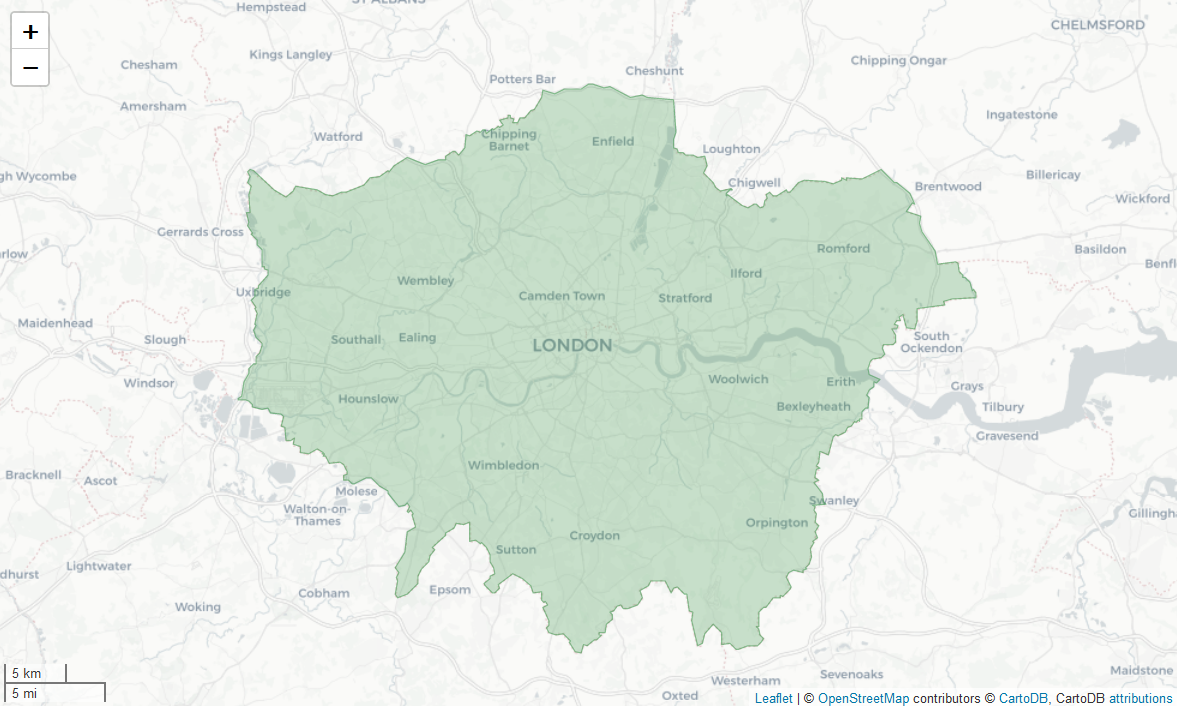

In [83]:
#storing current zoom and bounds for future plots
current_map_bounds = london_map.get_bounds()

## Getting all the Stadiums in London

In [11]:
tags = {'leisure': 'stadium'}
stadiums = ox.geometries_from_place(place, tags) #getting the stadiums with place and tag
stadiums.head()

source  \
element_type osmid            
way          4253555  yahoo   
             4270349    NaN   
             4380344    NaN   
             4402122    NaN   
             5986169    NaN   

                                                               geometry  \
element_type osmid                                                        
way          4253555  POLYGON ((-0.34317 51.45675, -0.34211 51.45723...   
             4270349  POLYGON ((-0.03765 51.63205, -0.03656 51.63185...   
             4380344  POLYGON ((-0.22292 51.47550, -0.22293 51.47548...   
             4402122  POLYGON ((-0.06274 51.65973, -0.06275 51.65961...   
             5986169  POLYGON ((-0.19076 51.48097, -0.19061 51.48084...   

                     tourism                         name wheelchair  \
element_type osmid                                                     
way          4253555     NaN           Twickenham Stadium        NaN   
             4270349     NaN  Lee Valley Athletics Centre        NaN   
             4380344     NaN               Craven Cottage        NaN   
             4402122     NaN  The Queen Elizabeth Stadium        NaN   
             5986169     NaN              Stamford Bridge        yes   

                     description layer  \
element_type osmid                       
way          4253555         NaN   NaN   
             4270349         NaN   NaN   
             4380344         NaN   NaN   
             4402122         NaN   NaN   
             5986169         NaN   NaN   

                                                                  nodes  \
element_type osmid                                                        
way          4253555  [25472652, 25472653, 25472655, 1574389714, 254...   
             4270349  [25638120, 8770493876, 21626670, 21626669, 256...   
             4380344  [26731311, 4958387652, 4958387664, 4958387840,...   
             4402122  [26915119, 26915245, 4729839259, 4729839247, 4...   
             5986169  [1386355942, 1386355945, 49328511, 49328512, 1...   

                       addr:city addr:housenumber  ... name:ta name:th  \
element_type osmid                                 ...                   
way          4253555  Twickenham              200  ...     NaN     NaN   
             4270349      London               61  ...     NaN     NaN   
             4380344      London              NaN  ...     NaN     NaN   
             4402122     Enfield              NaN  ...     NaN     NaN   
             5986169      London              NaN  ...     NaN     NaN   

                     name:tr name:tt name:ur name:uz name:vi name:wuu  \
element_type osmid                                                      
way          4253555     NaN     NaN     NaN     NaN     NaN      NaN   
             4270349     NaN     NaN     NaN     NaN     NaN      NaN   
             4380344     NaN     NaN     NaN     NaN     NaN      NaN   
             4402122     NaN     NaN     NaN     NaN     NaN      NaN   
             5986169     NaN     NaN     NaN     NaN     NaN      NaN   

                     name:xmf name:yue  
element_type osmid                      
way          4253555      NaN      NaN  
             4270349      NaN      NaN  
             4380344      NaN      NaN  
             4402122      NaN      NaN  
             5986169      NaN      NaN  

[5 rows x 130 columns]

## Selecting only the Stadiums with Clubs in the Premier League or the EFL

In [12]:
sel_stadiums = df['Stadium'].to_list() # list of selected stadiums

# there are only 8, probably there is a second name to the others
sel_stadiums_df = stadiums.loc[stadiums['name'].isin(sel_stadiums)]
len(sel_stadiums_df)

8

In [13]:
# listing the stadiums not in sel_stadiums_df
to_adjust_name = [x for x in sel_stadiums if x not in sel_stadiums_df['name'].to_list()]
to_adjust_name

['Brentford Community Stadium',
 'Kiyan Prince Foundation Stadium',
 'Plough Lane',
 'Brisbane Road',
 'Gander Green Lane']

In [14]:
def extract_stadium_name(ls, signal = ' Stadium'):
    correct_names = list()
    for name in ls:
        # downloading first name result on OSM specifying that I am looking for a stadium
        try:
            search = ox.geocode_to_gdf(name+signal, which_result=1)
            long_name = search['display_name'][0]
        except:
            long_name = name + ', '
        
        long_name = long_name.split(',')[0] # removing the part of the results beyond the first comma
        
        correct_names.append(long_name)
        
    return correct_names

In [15]:
correct_names = extract_stadium_name(to_adjust_name)
correct_names

['Gtech Community Stadium',
 'Loftus Road Stadium',
 'Plough Lane Stadium',
 'Breyer Group Stadium',
 'Tooting and Mitcham United FC']

In [16]:
# replacing the name in the stadiums df to repeat the query on the gdf
for n in range(len(correct_names)):
    df = df.replace(to_replace=to_adjust_name[n], value=correct_names[n])

<b> Now I have the correct stadiums data:</b>

In [17]:
# REPEAT QUERY
sel_stadiums = df['Stadium'].to_list() # list of selected stadiums

# there are only 8, probably there is a second name to the others
sel_stadiums_df = stadiums.loc[stadiums['name'].isin(sel_stadiums)]

# cleaning the dataframe from Null columns
sel_stadiums_df = sel_stadiums_df.dropna(axis=1)
len(sel_stadiums_df)

13

## Adding the Clubs to the geoDF

In [18]:
# renaming the df column Stadium with name to be identical to 
df = df.rename(columns={'Stadium':'name'})

In [19]:
# joining the geoDF with the df on the stadium name which must correspond
data = sel_stadiums_df.merge(df, on = 'name')

## Getting the Clubs location

In [20]:
# Looking for the points/addresses on Open Street Map

address = list()
for n, name in enumerate(data['Club']):
    #if it finds the address add it
    try:
        search = ox.geocode_to_gdf(name + ' FC, London', which_result=1)
        address.append((name, search['geometry'][0].centroid))
        
    #otherwise it is the same of the stadium
    except:
        address.append((name, data.loc[n]['geometry'].centroid))

In [21]:
address

[('Fulham', <shapely.geometry.point.Point at 0x1ca0dfb8550>),
 ('Chelsea', <shapely.geometry.point.Point at 0x1ca0dfb8a00>),
 ('Millwall', <shapely.geometry.point.Point at 0x1ca0dfb8d00>),
 ('Leyton Orient', <shapely.geometry.point.Point at 0x1ca0d927f70>),
 ('Queens Park Rangers', <shapely.geometry.point.Point at 0x1ca0dfb8220>),
 ('Sutton United', <shapely.geometry.point.Point at 0x1ca0dfb8400>),
 ('Arsenal', <shapely.geometry.point.Point at 0x1ca0dfb8100>),
 ('West Ham United', <shapely.geometry.point.Point at 0x1ca0daeaeb0>),
 ('Tottenham Hotspur', <shapely.geometry.point.Point at 0x1ca0d927c40>),
 ('Brentford', <shapely.geometry.point.Point at 0x1ca0d927ac0>),
 ('Crystal Palace', <shapely.geometry.point.Point at 0x1ca0daea370>),
 ('Charlton Athletic', <shapely.geometry.point.Point at 0x1ca0d927850>),
 ('AFC Wimbledon', <shapely.geometry.point.Point at 0x1ca0daea9d0>)]

In [22]:
data = data.merge(pd.DataFrame(address, columns = ['Club', 'Club_Location']), on = 'Club')

In [23]:
data.head()

,geometry,name,nodes,leisure,sport,wikidata,wikipedia,Club,Capacity,Founded,Notes,league,Club_Location
0,"POLYGON ((-0.22292 51.47550, -0.22293 51.47548...",Craven Cottage,"[26731311, 4958387652, 4958387664, 4958387840,...",stadium,soccer,Q318043,en:Craven Cottage,Fulham,25700.0,1879.0,Oldest London club in the Football League.,Premier League,POINT (-0.2452775239622635 51.39314926025112)
1,"POLYGON ((-0.19076 51.48097, -0.19061 51.48084...",Stamford Bridge,"[1386355942, 1386355945, 49328511, 49328512, 1...",stadium,soccer,Q171458,en:Stamford Bridge (stadium),Chelsea,41798.0,1905.0,Won the last ever FA Cup final at the old Wemb...,Premier League,POINT (-0.1909454986627079 51.481720366343794)
2,"POLYGON ((-0.05133 51.48671, -0.05136 51.48673...",The Den,"[63215233, 7563134283, 7563134282, 7563134281,...",stadium,soccer,Q908481,en:The Den,Millwall,20146.0,1885.0,"Founded in East London on the Isle of Dogs, mo...",EFL Championship,POINT (-0.0212187 51.4933423)
3,"POLYGON ((-0.01342 51.56036, -0.01359 51.56056...",Breyer Group Stadium,"[92722191, 2007457256, 881443891, 2007457324, ...",stadium,soccer,Q917727,en:Brisbane Road,Leyton Orient,9271.0,1881.0,Leyton Orient was originally formed by members...,EFL League Two,POINT (-0.0126382222373926 51.56010546777598)
4,"POLYGON ((-0.23314 51.50886, -0.23108 51.50879...",Loftus Road Stadium,"[8589290635, 2238131506, 8630871974, 185747793...",stadium,soccer,Q31670,en:Loftus Road,Queens Park Rangers,18439.0,1882.0,Played in various grounds notably the White Ci...,EFL Championship,POINT (-0.2321134963983055 51.509348701832785)


## Visualizing the Clubs and Stadiums

In [ ]:
#here I looped through the rows coloring red the points from which to end the route
#adding Stadium Geometries on the map
for _, d in data.iterrows():
    folium.GeoJson(d['geometry'],
                   style_function= lambda x :{'color':'red', 'fillColor':'red'}
                  ).add_to(london_map) #adding the geometry of the cs departement and cnr in green

#adding Markers for the Clubs
for _, d in data.iterrows():
    folium.Marker(flip_xy(d['Club_Location']), #the location of the marker
                  popup=d['Club'], #its name
                  icon=folium.Icon(color='green') #the color of the icon
                 ).add_to(london_map)

#visualizing the result
london_map

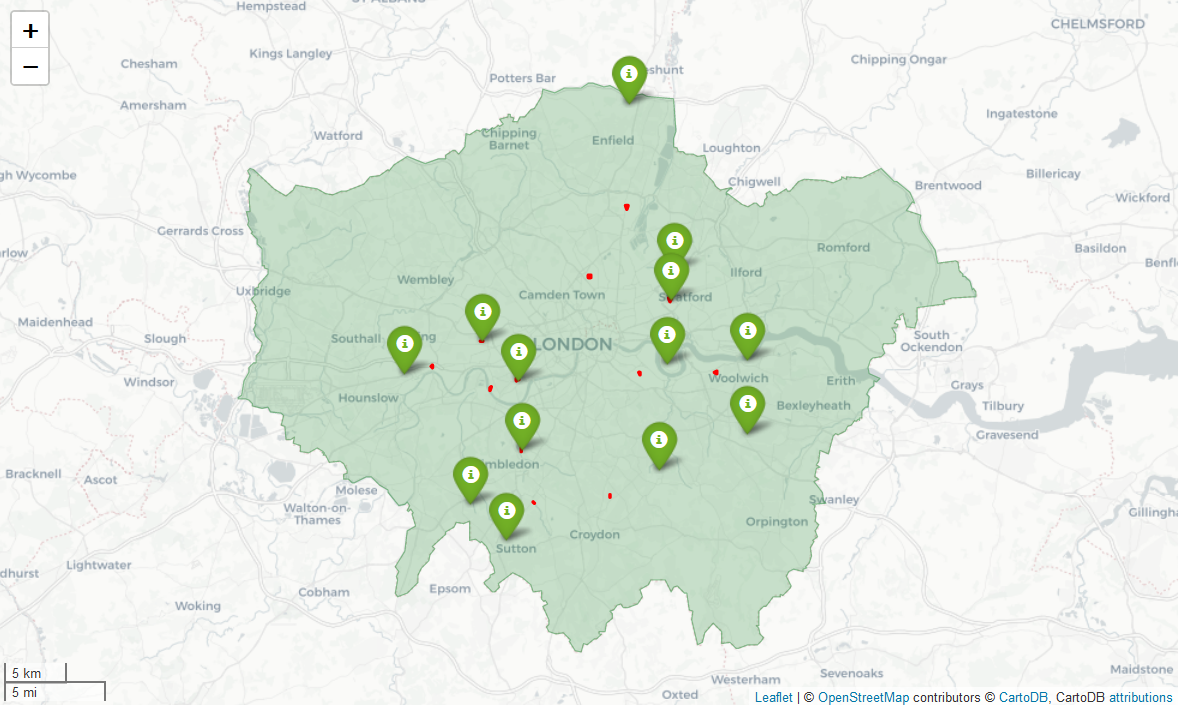

## Downloading and Loading the Road Network

I had an unstable connection at home, thus I downloaded the road network in Colab and saved it, then I downloaded it with drive and loaded it in the next cell

``` Python
G = ox.graph_from_place('London, United Kingdom', network_type="walk")
ox.io.save_graphml(G, filepath='london_walk.osm')
```

In [25]:
G = ox.io.load_graphml(filepath='london_walk.osm')

## Computing the Shortest Path between Clubs and their stadiums

In [45]:
plotting_route_list = list()

for _, d in data.iterrows(): #for each row of the data
    orig = d['Club_Location'] #get club location as origin
    dest = d['geometry'].centroid #get stadium centroid location as destination
    
    #computing nearest origin and destination nodes
    orig_node = ox.distance.nearest_nodes(G, X=orig.x, Y=orig.y)
    dest_node = ox.distance.nearest_nodes(G, X=dest.x, Y=dest.y)
    
    #computing the shortest route between them by travel time
    route = ox.shortest_path(G, orig_node, dest_node, weight="travel_time")
    
    #adding to a list the name of the club, the name of the stadium and the route
    plotting_route_list.append((d['Club'], d['name'], route))

In [80]:
#looping across the list I made to plot the routes
for el in plotting_route_list:
    route = el[2]
    try: #if it doesn't finde edges it means the route has no distance, the Stadium is in the same place of the Club
        ox.plot_route_folium(G, route, route_map=london_map)
    except: #if it's in the same place move to the next route
        pass

In [81]:
#refitting the map bounds to the original one to get a whole view over London
london_map.fit_bounds(current_map_bounds)

## Visualizing the shortest path from a club to its Stadium

In [ ]:
#as it can be seen some stadiums are in the same place of the club headquarters
london_map

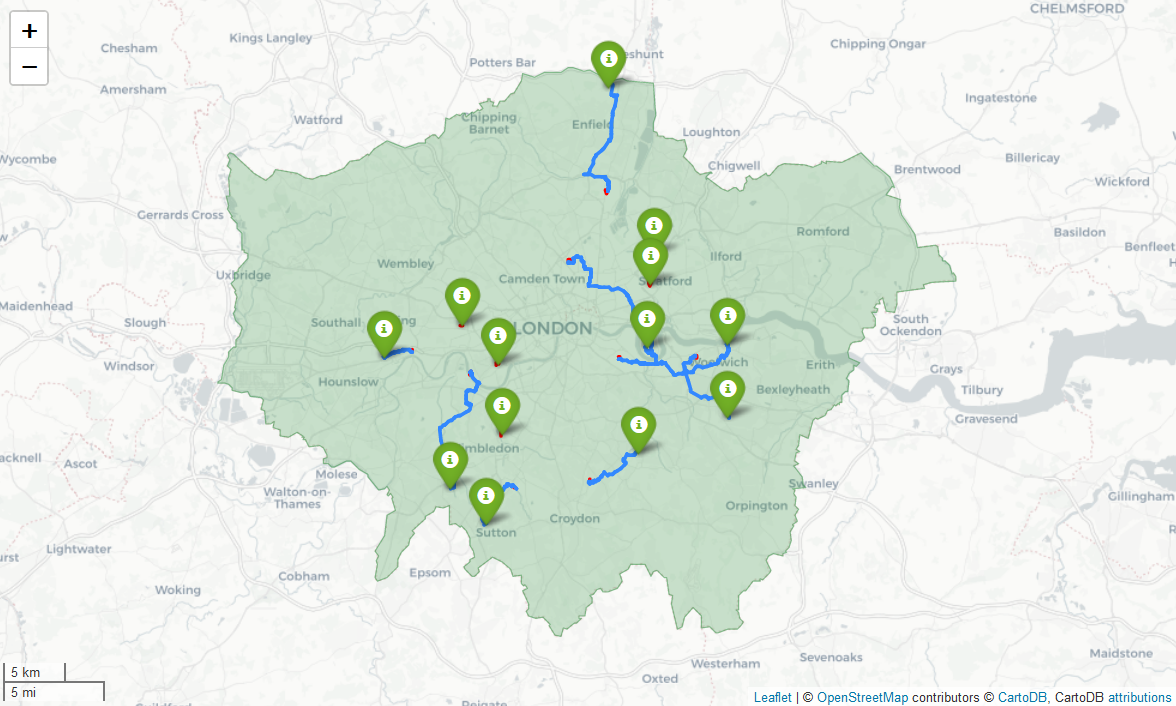

## Computing total distance from each headquarters to the League opponents' stadiums

In [88]:
leagues = data['league'].unique()
leagues

array(['Premier League', 'EFL Championship', 'EFL League Two',
       'EFL League One'], dtype=object)

In [95]:
#it takes a while to compute

dist_list = list()

for leag in leagues: #looping across different leagues
    leag_data = data[data['league'] == leag]
    
    for _, d1 in leag_data.iterrows(): #looping twice across the rows
        for _, d2 in leag_data.iterrows():
            if d1['geometry'] != d2['geometry']: #if comparing two rows they have different stadiums (different rows), then:
                orig = d1['Club_Location'] #get club location as origin
                dest = d2['geometry'].centroid #get the opponent's stadium centroid location as destination

                #computing nearest origin and destination nodes
                orig_node = ox.distance.nearest_nodes(G, X=orig.x, Y=orig.y)
                dest_node = ox.distance.nearest_nodes(G, X=dest.x, Y=dest.y)

                #computing the shortest route between them by travel time
                route = ox.shortest_path(G, orig_node, dest_node, weight="travel_time")
                
                #computing how long is the route in meters
                edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
                total_dist = sum(edge_lengths)

                #adding to a list the name of the club, the name of the stadium and the total distance of the route
                dist_list.append((leag, d1['Club'], d2['name'], total_dist))

## Showing total Distances by League as a DataFrame

In [96]:
# showing the results
result = pd.DataFrame(dist_list, columns=['League', 'From_Club', 'To_Stadium', 'Total_Distance'])
result.head()

,League,From_Club,To_Stadium,Total_Distance
0,Premier League,Fulham,Stamford Bridge,14399.974
1,Premier League,Fulham,Emirates Stadium,32066.897
2,Premier League,Fulham,London Stadium,34305.190
3,Premier League,Fulham,Tottenham Hotspur Stadium,43002.864
4,Premier League,Fulham,Gtech Community Stadium,14630.553


In [105]:
# formatting the results to be more readable
result['Readable_Tot_Dist'] = round(readable_results['Total_Distance'] / 1000, 2).astype(str) + ' km'
result

,League,From_Club,To_Stadium,Total_Distance,Readable_Tot_Dist
0,Premier League,Fulham,Stamford Bridge,14399.974,14.4 km
1,Premier League,Fulham,Emirates Stadium,32066.897,32.07 km
2,Premier League,Fulham,London Stadium,34305.190,34.31 km
3,Premier League,Fulham,Tottenham Hotspur Stadium,43002.864,43.0 km
4,Premier League,Fulham,Gtech Community Stadium,14630.553,14.63 km
5,Premier League,Fulham,Selhurst Park,15392.291,15.39 km
6,Premier League,Chelsea,Craven Cottage,3102.184,3.1 km
7,Premier League,Chelsea,Emirates Stadium,15091.148,15.09 km
8,Premier League,Chelsea,London Stadium,20574.488,20.57 km
9,Premier League,Chelsea,Tottenham Hotspur Stadium,35158.982,35.16 km
